# A/B and A/A tests and the power to detect a difference on a binary task (e.g. churn or propensity to buy)

A/B tests are used to detect a difference in two populations. Here we look at churn on 2 cohorts who have a low churn rate (5%), we'd like to determine how many people we need to sample to reliably detect an improvement in churn by 5% (i.e. 5%->4.75% churn improvement). The necessary sample size is probably larger than we'd desire!

The two papers below discuss ways to reduce variance and thereby increase the statistic power of a test (here we're using a ChiSq test on counts of a simulated binary outcome). 

Detecting small changes requires a huge population. Detecting large changes (which are more likely to occur if you break something that was good, than if you improve something that was already good) is easier.

If you don't control for statistical power you're likely to have test groups that are too small, so you rarely know that you've seen a real change, leading to rejections of small but useful improvements.

_Sidenote_ - fixing churn is hard anyhow as folk who will churn will do so for lots of reasons (e.g. dissatisfaction, price, low use of product) so it is more likely that this is a product design test than a machine-learning led intervention.
  
Two good papers:
 * "Trustworthy Online Controlled Experiments: Five Puzzling Outcomes Explained, 2012 (KDD), Kohavi, Deng, Frasca, Longbotham, Walker, Xu" (https://dl.acm.org/doi/10.1145/2339530.2339653)
 * "Practical Guide to Controlled Experiments on the Web, 2007 (KDD), Kohavi, Henne, Sommerfield" (https://courses.cs.washington.edu/courses/cse454/15au/papers/p959-kohavi.pdf) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import tqdm
import sys

from scipy.stats import chi2_contingency

def set_common_mpl_styles(
    ax, legend=True, grid_axis="y", ylabel=None, xlabel=None, title=None, ymin=None,
    xmin=None
):
    ax.grid(axis=grid_axis)
    if legend == False:
        ax.legend_.remove()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if title is not None:
        ax.set_title(title)
    if ymin is not None:
        ax.set_ylim(ymin=ymin)
    if xmin is not None:
        ax.set_xlim(xmin=xmin)

In [2]:
# Check on usage of chi2, given a contingency table we get a pvalue and expectation
# If the contingency table significantly diverges from the expected values then we
# get a small pvalue, if the tables are roughly the same then the pvalue is close to 1.0
obs = np.array([[50, 50], [28, 71]])
import pprint
pprint.pprint(obs)
chi2, pvalue, dof, expected = chi2_contingency(obs)
# a pvalue < 0.05 means we can rejected the NH (NH: distributions are the same)
# and accept the AH of different distributions, with an expected error rate
# that we incorrectly reject the NH 5% of the time when there's no actual difference
print(f'pvalue for this result {pvalue:0.2f}') 
print('Expected frequencies:')
print(expected)

array([[50, 50],
       [28, 71]])
pvalue for this result 0.00
Expected frequencies:
[[39.1959799 60.8040201]
 [38.8040201 60.1959799]]


```
Each experiment is repeated 10k times to get the general behaviour.

The NH is that the distributions are the same (no difference between the A and B groups). On an A A test we would hope not to see any rejections (but they'll occur due to random variation). 

The AH is that the groups come from different distributions.

First we'll perform an A A test on 5k people (10k total). 5% of group A and B churn (i.e. they're the same - no intervention). On 4% of runs the NH is rejected. 96% of the time the NH is accepted. Even in this case we incorrectly see "a difference" on 4% of the experiments.

Whilst 4% or so might be rejected, we'd expect a 5% rejection if we did _lots_ more experiments (we're testing at the 5% level so we expect 5% false NH rejections).

Next we run an A B test on the same groups (10k people in total). 5% of group A churn, 4.75% of group B churn i.e. group B is 5% less likely to churn - we'd like to detect this difference by rejecting the NH. This time we reject the NH 8% of the time (i.e. we detect this small difference but not much more frequently than for the A A test), so 92% of the time we believe there's no difference between these groups (which is wrong). Subtle differences on small groups are not reliably detectable.

Next we run an A B test on the same groups, this time group B is 20% less likely to churn (group A churns at 5%, group B churns at 4%). With this larger difference we reject the NH 65% of the time (so 2/3 of the time we correctly identify that the difference is significant). 1/3 of the time we still believe there's no difference. 

If each marketing experiment is run only once, using a larger cohort than is currently used (i.e. the 10k proposed above), we'd still see high variance in the results.

To reliably detect a relatively large 20% change in churn we'd need a population of 20k people under study (two groups of 10k each), this lets us identify the difference on 90% of the runs (i.e. we'd still see the wrong answer 10% of the time). Thus the power of this configuration is 90% (which is a commonly accepted level).

To detect a smaller improvement (which is more likely to be the case) we start to need significantly larger test groups.

To reliably detect a smaller 5% change in churn (assuming churn is 5% at the start) we'd need a population of 320,000 people in total, to get the correct answer 90% of the time. The research paper noted below has an estimator formula, it suggests we'd need circa 480k people to achieve this accuracy. This formula seems to overestimate but roughly gives the same answer as the simulation, so it is a useful and quick guide.

With 2,000,000 people in total (1M per group), in an A/A test, we reject the NH 5% of the time. With an A/B test with a very tiny variation (10^-7) we detect this change barely above the 5% level i.e. we can't detect very tiny changes even with a huge sample (we'd need an even-huger sample for this).
```

In [3]:
REPEATS = 10_000

PEOPLE_A = 10_000
PEOPLE_B = 10_000

CUTOFF_A = 0.05 # 5% churn
#B_MODIFIER = 1.0 # 1.0 means no change
#B_MODIFIER = 0.95 # 0.95 means go down by 5% (i.e. improve churn by 5%)
B_MODIFIER = 0.8 # 0.8 means go down by 20% (i.e. improve churn by 20%)
CUTOFF_B = CUTOFF_A * B_MODIFIER 

print(f'{PEOPLE_A:,} in A, {PEOPLE_B:,} in B')
print(f'P(churn|A) == {CUTOFF_A*100:0.2f}%, P(churn|B) == {CUTOFF_B*100:0.2f}%')

10,000 in A, 10,000 in B
P(churn|A) == 5.00%, P(churn|B) == 4.00%


### Estimate using "Practical Guide to Controlled Experiments on the Web" (paper) formula

Using "Practical Guide to Controlled Experiments on the Web, 2007 (KDD), Kohavi, Henne, Sommerfield" (https://courses.cs.washington.edu/courses/cse454/15au/papers/p959-kohavi.pdf) we can estimate how many participants we need to track if we're going to do a >90% power 2 category ChiSq test.

**NOTE** that this estimation method _overestimates_ the number of samples required, but is correct (given my experiments) within a factor of 2.

In [4]:
# "Practical Guide to Controlled Experiments on the Web, 2007 (KDD), Kohavi, Henne, Sommerfield"
NBR_VARIANTS = 2
DESIRED_LEVEL_OF_CHANGE_TO_DETECT = max(1-B_MODIFIER, 0.0000000001) # avoid 0 else this estimator fails
STD_DEV_OEC = np.sqrt(CUTOFF_A * (1-CUTOFF_A)) # std dev of Bernoulli trial on an X% event e.g. 5% churn rate
DELTA = CUTOFF_A * DESIRED_LEVEL_OF_CHANGE_TO_DETECT
nbr_trials_we_need = int((4 * NBR_VARIANTS * STD_DEV_OEC / (DELTA)) ** 2)
print(f"According to the _estimate_ formula we'll need {nbr_trials_we_need:,} participants in total")
print('Note that this formula is quick and it over-estimates the population size')

According to the _estimate_ formula we'll need 30,400 participants in total
Note that this formula is quick and it over-estimates the population size


In [5]:
NEW_B_MODIFIERS = [0.95, 0.9, 0.85, 0.8, 0.75] # reduce churn by a set of 
#NEW_B_MODIFIERS = np.arange(0.99, 0.85, -0.01)
total_estimated_participants = []
results_to_plot = []
for new_b_modifier in NEW_B_MODIFIERS:
    NBR_VARIANTS = 2
    DESIRED_LEVEL_OF_CHANGE_TO_DETECT = max(1-new_b_modifier, 0.0000000001) # avoid 0 else this estimator fails
    STD_DEV_OEC = np.sqrt(CUTOFF_A * (1-CUTOFF_A)) # std dev of Bernoulli trial on an X% event e.g. 5% churn rate
    DELTA = CUTOFF_A * DESIRED_LEVEL_OF_CHANGE_TO_DETECT
    nbr_trials_we_need = int((4 * NBR_VARIANTS * STD_DEV_OEC / (DELTA)) ** 2)
    total_estimated_participants.append(nbr_trials_we_need)
    results_to_plot.append({'change_to_detect': (1-new_b_modifier)*100, 'nbr_trials': nbr_trials_we_need})

def set_human_format(ax, on_x_axis=False, on_y_axis=False, **kwargs):
    '''Add commas e.g. 1_000_000 -> "1,000,000"'''
    # note hardcoded in this case to the one plot I'm using below
    if on_x_axis == False and on_y_axis == False:
        raise ValueError("An axis must be chosen!")
    if on_x_axis:
        axis = ax.get_xaxis()
        axis.set_major_formatter(
            mpl.ticker.FuncFormatter(lambda x, p: f"{results_to_plot_df.index[x]:0.0f}%")
        )
    if on_y_axis:
        axis = ax.get_yaxis()
        axis.set_major_formatter(
            mpl.ticker.FuncFormatter(lambda x, p: f"{int(x):,}")
        )

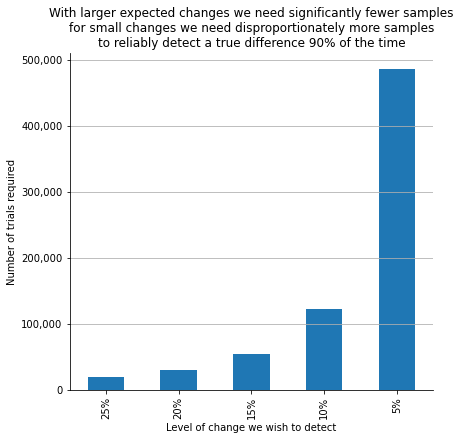

In [6]:
fig, axs = plt.subplots(figsize=(6, 6), constrained_layout=True)
ax = axs
results_to_plot_df = pd.DataFrame(results_to_plot).set_index('change_to_detect').sort_index(ascending=False)
results_to_plot_df.plot(kind='bar', ax=ax, )

title = 'With larger expected changes we need significantly fewer samples\nfor small changes we need disproportionately more samples\nto reliably detect a true difference 90% of the time'
set_common_mpl_styles(ax, title=title, ylabel='Number of trials required',
                      xlabel = 'Level of change we wish to detect', ymin=0, legend=False)
#results_to_plot.style.format({'nbr_trials':"0.0f%"})
set_human_format(ax, on_y_axis=True, on_x_axis=True)

### Monte Carlo simulation result

In [7]:
pvalues = []
print(f'{PEOPLE_A:,} in A, {PEOPLE_B:,} in B')
print(f'P(churn|A) == {CUTOFF_A*100:0.2f}%, P(churn|B) == {CUTOFF_B*100:0.2f}%')
sys.stdout.flush() # ignore print conflict with tqdm
nbr_times_mean_a_gt_mean_b = []
mean_a = []
mean_b = []

for rep in tqdm.tqdm(range(REPEATS)):
    # real values in the continuous uniform range [0, 1)
    # then cast to ints (0 or 1) for chi sq frequency table
    arr_a = (np.random.random_sample(size=PEOPLE_A) < CUTOFF_A).astype('int')
    arr_b = (np.random.random_sample(size=PEOPLE_B) < CUTOFF_B).astype('int')
    # create a chi sq frequency table (as above)
    obs = [[arr_a.sum(), arr_a.shape[0]-arr_a.sum()], [arr_b.sum(), arr_b.shape[0]-arr_b.sum()]]
    chi2, pvalue, dof, expected = chi2_contingency(obs)
    pvalues.append(pvalue)
    
    mean_a.append(arr_a.mean())
    mean_b.append(arr_b.mean())
    nbr_times_mean_a_gt_mean_b.append(arr_a.mean() > arr_b.mean())

pvalues = np.array(pvalues) # turn list to array
sys.stderr.flush()
print('Calculate nbr of times we reject NH of no-difference:')
print(f'{sum(pvalues < 0.05) / REPEATS * 100:0.1f}% Null Hyp rejects (NH: No difference in distributions)')
# Calculate how often mean_a > mean_b, if we had a significant result we would then follow
# this guidance which for an A A test would mean a random choice (as mean_a==mean_b==50%)
fraction_time_mean_a_gt_mean_b = sum(nbr_times_mean_a_gt_mean_b) / len(nbr_times_mean_a_gt_mean_b)
print(f'Percentage of time mean-A is greater than mean-B: {fraction_time_mean_a_gt_mean_b*100:0.2f}%')

10,000 in A, 10,000 in B
P(churn|A) == 5.00%, P(churn|B) == 4.00%


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1455.34it/s]


Calculate nbr of times we reject NH of no-difference:
92.2% Null Hyp rejects (NH: No difference in distributions)
Percentage of time mean-A is greater than mean-B: 99.95%


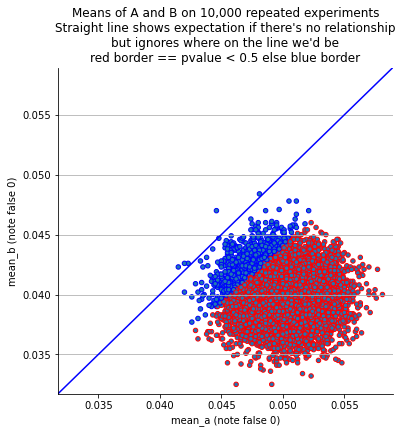

In [8]:
df = pd.DataFrame({'mean_a': mean_a, 'mean_b': mean_b})
fig, axs = plt.subplots(figsize = (6, 6), ncols=1, sharey=True)
ax = axs
border_color = ['r' if v==True else 'b' for v in pvalues < 0.05] # r if reject NH
df.plot(kind='scatter', x='mean_a', y='mean_b', ax=ax, alpha=1, edgecolors=border_color)
title = f'Means of A and B on {len(mean_a):,} repeated experiments'
title += "\nStraight line shows expectation if there's no relationship"
title += "\nbut ignores where on the line we'd be"
title += "\nred border == pvalue < 0.5 else blue border"
set_common_mpl_styles(ax, ylabel='mean_b (note false 0)', xlabel='mean_a (note false 0)', title=title)
min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(xmin=min_val, xmax=max_val)
ax.set_ylim(ymin=min_val, ymax=max_val);
ax.plot([min_val, max_val], [min_val, max_val], color='blue');

## Plot distribution of pvalues from this test 

The left-most bin counts the number of times we've seen a pvalue < 0.05. We can visually see if the pvalues are evenly distributed (which suggests an A A test) or if they're biased one way, if biased to the left then it suggests for a large enough set of repeats that we're seeing a difference in the population.

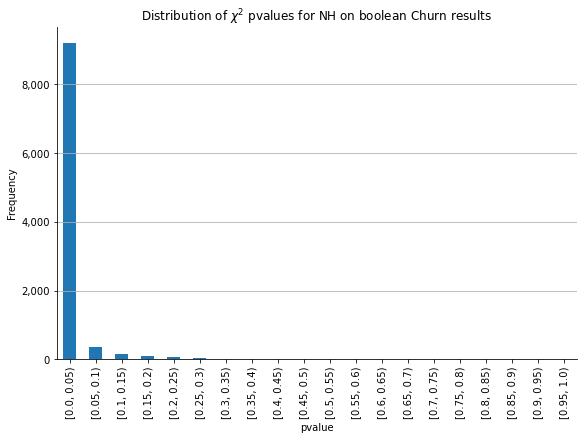

In [11]:
fig, axs = plt.subplots(figsize = (8, 6), ncols=1, sharey=True, constrained_layout=True)
bins = np.linspace(0, 1, 21)
ax = axs
ser = pd.cut(pd.Series(pvalues), bins, right=False).value_counts().sort_index()
ser.plot(kind='bar')
set_common_mpl_styles(ax, ymin=-1, ylabel='Frequency', xlabel='pvalue',
                      title=r"Distribution of $\chi^2$ pvalues for NH on boolean Churn results")

ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [12]:
df = pd.DataFrame({'A': arr_a, 'B': arr_b})
print('A and B groups with no-churn (0) and churn (1)')
labels = {0:'no churn', 1: 'churn'}
pd.crosstab(df['A'], df['B'], margins=True, normalize=True). \
rename(columns=labels, index=labels).style.format('{:.2%}')

A and B groups with no-churn (0) and churn (1)


B,no churn,churn,All
A,,,
no churn,91.55%,3.72%,95.27%
churn,4.50%,0.23%,4.73%
All,96.05%,3.95%,100.00%
